In [50]:
import sys 
sys.path.append("../") # שבשורה למטה instrumentCollectionשני השורות העלינות כדי שניתן יהיה למצוא את ה
import pandas as pd
import plotly.graph_objects as go
import datetime as dt
from plotting import CandlePlot

In [52]:
from infrastructure.instrument_collection import instrumentCollection as ic

In [90]:
pair = "GBP_JPY"
granularity = "H4"   #נר של 4 שעות
df = pd.read_pickle(f"../data/{pair}_{granularity}.pkl")
MA_LIST = [10, 20, 50, 100, 200]

In [91]:
df_ma= df[['time','mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [92]:
df_ma.head()

,time,mid_o,mid_h,mid_l,mid_c
0,2021-01-24 22:00:00+00:00,142.053,142.140,141.962,142.080
1,2021-01-25 02:00:00+00:00,142.082,142.248,142.077,142.248
2,2021-01-25 06:00:00+00:00,142.250,142.328,141.843,141.932
3,2021-01-25 10:00:00+00:00,141.935,142.196,141.888,141.990
4,2021-01-25 14:00:00+00:00,141.988,142.034,141.657,141.876


In [93]:
for ma in MA_LIST:
    df_ma[f'MA_{ma}'] = df_ma.mid_c.rolling(window=ma).mean()    
df_ma.dropna(inplace = True)
df_ma.reset_index(inplace=True, drop=True)

In [94]:
df_plot = df_ma.iloc[0:500] # the first 100

In [95]:
df_plot.shape

(500, 10)

In [96]:
cp = CandlePlot(df_plot)

In [97]:
# cp.fig.add_trace(go.Scatter(
#     x=cp.df_plot.sTime,
#     y=cp.df_plot.MA_10,
#     line=dict(width=2),
#     line_shape="spline",
#     name="MA_10"))
# cp.show_plot()

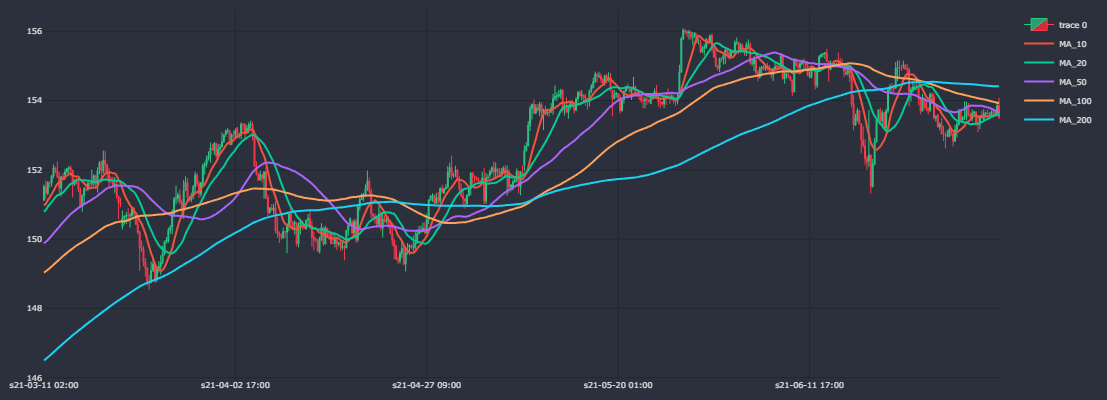

In [98]:
cp.show_plot(line_traces=[f"MA_{ma}" for ma in MA_LIST])

In [123]:
MA_S="MA_50"
MA_L="MA_200"
BUY=1
SELL=-1
NONE=0

In [124]:
df_an=df_ma[['time','mid_o', 'mid_h', 'mid_l', 'mid_c', MA_S, MA_L]].copy()

In [125]:
df_an.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_50,MA_200
0,2021-03-11 02:00:00+00:00,151.114,151.572,151.114,151.517,149.87812,146.496070
1,2021-03-11 06:00:00+00:00,151.520,151.690,151.152,151.319,149.92194,146.542265
2,2021-03-11 10:00:00+00:00,151.316,151.671,151.274,151.625,149.97520,146.589150
3,2021-03-11 14:00:00+00:00,151.622,151.672,151.478,151.617,150.03064,146.637575
4,2021-03-11 18:00:00+00:00,151.614,151.838,151.512,151.832,150.09440,146.686785


In [127]:
df_an['DELTA']=df_an.MA_50-df_an.MA_200

In [128]:
df_an['DELTA_PREV']=df_an.DELTA.shift(1)

In [129]:
def is_trade(row):
    if row.DELTA>=0 and row.DELTA_PREV<0:
        return BUY
    elif row.DELTA<0 and row.DELTA_PREV>=0:
        return SELL
    return NONE

In [130]:
df_an['TRADE']=df_an.apply(is_trade, axis='columns')

In [131]:
df_trades=df_an[df_an.TRADE != NONE].copy()
df_trades.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_50,MA_200,DELTA,DELTA_PREV,TRADE
153,2021-04-15 13:00:00+00:00,149.988,149.994,149.690,149.856,150.82828,150.902175,-0.073895,0.000280,-1
233,2021-05-04 21:00:00+00:00,151.845,152.005,151.760,151.959,150.96454,150.949005,0.015535,-0.027730,1
437,2021-06-21 21:00:00+00:00,153.628,153.776,153.306,153.411,154.30770,154.323890,-0.016190,0.017955,-1
647,2021-08-09 21:00:00+00:00,152.768,152.905,152.712,152.815,152.50896,152.508625,0.000335,-0.010650,1
689,2021-08-18 21:00:00+00:00,150.986,151.139,150.946,151.051,152.14970,152.150745,-0.001045,0.023490,-1


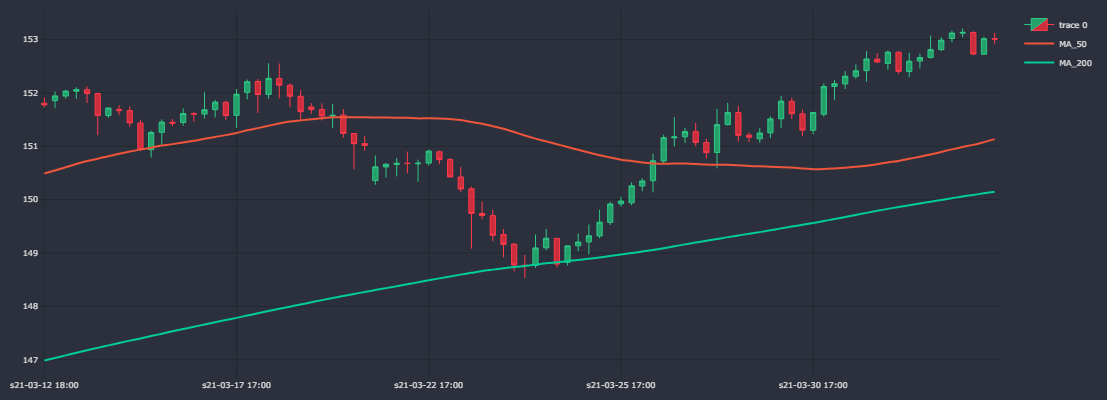

In [132]:
cp=CandlePlot(df_an.iloc[10:100])
cp.show_plot(line_traces=[MA_S, MA_L]) 

In [133]:
ic.LoadInstruments("../data")

In [134]:
ic.instrument_dict[pair] #pair="EUR_USD"

{'name': 'GBP_JPY', 'ins_type': 'CURRENCY', 'displayName': 'GBP/JPY', 'pipLocation': 0.01, 'tradeUnitsPrecision': 0, 'marginRate': 0.05}

In [135]:
ins_data = ic.instrument_dict[pair] #pair="EUR_USD"

In [136]:
df_trades['DIFF'] = df_trades.mid_c.diff().shift(-1)
df_trades.fillna(0, inplace=True)

In [137]:
df_trades['GAIN']= df_trades.DIFF / ins_data.pipLocation * df_trades.TRADE

In [138]:
df_trades.head()

,time,mid_o,mid_h,mid_l,mid_c,MA_50,MA_200,DELTA,DELTA_PREV,TRADE,DIFF,GAIN
153,2021-04-15 13:00:00+00:00,149.988,149.994,149.690,149.856,150.82828,150.902175,-0.073895,0.000280,-1,2.103,-210.3
233,2021-05-04 21:00:00+00:00,151.845,152.005,151.760,151.959,150.96454,150.949005,0.015535,-0.027730,1,1.452,145.2
437,2021-06-21 21:00:00+00:00,153.628,153.776,153.306,153.411,154.30770,154.323890,-0.016190,0.017955,-1,-0.596,59.6
647,2021-08-09 21:00:00+00:00,152.768,152.905,152.712,152.815,152.50896,152.508625,0.000335,-0.010650,1,-1.764,-176.4
689,2021-08-18 21:00:00+00:00,150.986,151.139,150.946,151.051,152.14970,152.150745,-0.001045,0.023490,-1,0.777,-77.7


In [139]:
df_trades.GAIN.sum()

-6604.900000000009

In [140]:
df_trades['GAIN_C']= df_trades.GAIN.cumsum()

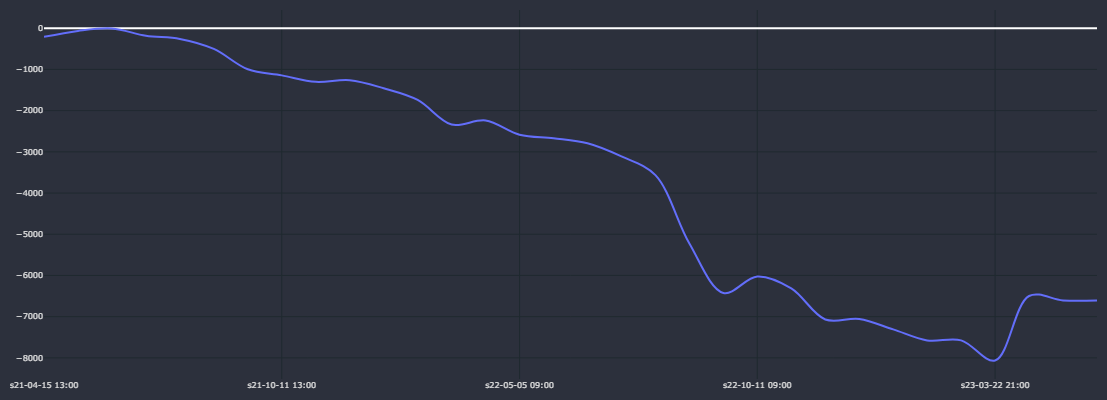

In [141]:
cp=CandlePlot(df_trades, False)
cp.show_plot(line_traces=['GAIN_C'])